In [ ]:
!install_tesseract.sh

## download

In [ ]:
%%bash
#download font

rm -r fonts 
mkdir -p fonts
cd fonts/

wget -nc   https://github.com/google/fonts/raw/main/ofl/kleeone/KleeOne-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/notoserifjp/NotoSerifJP%5Bwght%5D.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/mplus1p/MPLUS1p-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenantique/ZenAntique-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenkurenaido/ZenKurenaido-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenkakugothicantique/ZenKakuGothicAntique-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenoldmincho/ZenOldMincho-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenmarugothic/ZenMaruGothic-Regular.ttf

wget -nc https://github.com/google/fonts/raw/main/ofl/yujisyuku/YujiSyuku-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/yujiboku/YujiBoku-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/rampartone/RampartOne-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/dotgothic16/DotGothic16-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/hachimarupop/HachiMaruPop-Regular.ttf
wget -nc   https://github.com/google/fonts/raw/main/ofl/newtegomin/NewTegomin-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/kaiseiopti/KaiseiOpti-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/apache/kosugimaru/KosugiMaru-Regular.ttf




# https://github.com/google/fonts/raw/main/ofl/trainone/TrainOne-Regular.ttf
#   https://github.com/google/fonts/raw/main/ofl/reggaeone/ReggaeOne-Regular.ttf
#  https://github.com/google/fonts/raw/main/ofl/yomogi/Yomogi-Regular.ttf
# noto sans jp
# KaiseiDecol-Regular.ttf
# KiwiMaru-Regular.ttf
# fonts/RocknRollOne-Regular.ttf
# fonts/MochiyPopOne-Regular.ttf

In [ ]:
%%bash
#download model


cd model/
wget  -nc https://github.com/NbtKmy/jpn_vert_improvement/raw/main/traineddata/jpn_vert_v4.traineddata
wget  -nc https://github.com/zodiac3539/jpn_vert/raw/master/jpn_ver5.traineddata
wget  -nc https://github.com/tesseract-ocr/tessdata_best/raw/main/jpn_vert.traineddata



# # Extract the trainned model
combine_tessdata -u jpn_ver5.traineddata jpn_ver5

In [ ]:
%%bash
#download test data


cd test/
wget   -nc https://raw.githubusercontent.com/ttop32/JMTrans/master/doc/result1.png
cd ..

In [748]:
import os
cwd = os.getcwd()
os.environ["TESSDATA_PREFIX"] = cwd
import pytesseract
from PIL import Image               # to load images
from IPython.display import display # to display images
import cv2
import matplotlib.pyplot as plt
from glob import glob 
from fontTools import ttLib
from PIL import Image, ImageSequence
import re
import shutil
import random
from tqdm import tqdm
import numpy as np
from itertools import product
from pytesseract import Output
import json
import csv   
import pandas as pd
import parmap
from multiprocessing import Process, Lock, Manager
from functools import partial
import uuid
from tqdm.contrib.concurrent import process_map  # or thread_map
import time
import shutil
import os
import tempfile
from pathlib import Path

print(pytesseract.get_tesseract_version())




    
dataTxtFilteredPath="data_txt_filtered/"
dataTxtSplitPath="data_txt_split/"
dataLstmfTempPath="data_lstmf_temp/"




LANG="jpn"
MAX_PAGES=0  #0 for whole text
NUM_ITERATIONS=5000000

LANG_DATA_DIR="tesseract/langdata_lstm"
TESSDATA_DIR="tesseract/tessdata"
MODEL_DIR="model"
OUTPUT_DIR="output"
TRAIN_DIR="data_lstmf"

# TRAINING_TEXT="untitled.txt"
# TRAINING_TEXT=${LANG_DATA_DIR}/${LANG}/${LANG}.training_text 

OUTPUT_NAME="jpn_vert_new"
START_MODEL="jpn_ver5"



def resetFolder(path):
    if  os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)



5.3.0


## preprocess text data 




In [ ]:
#get model unicharset list
!combine_tessdata -u $MODEL_DIR/$START_MODEL".traineddata" $MODEL_DIR/$START_MODEL


uniPath= os.path.join(MODEL_DIR,START_MODEL+'.lstm-unicharset')
with open(uniPath, "r", encoding="UTF-8") as f:
    unicharsetLines = f.readlines()
    unicharsetList=[line[0] for line in unicharsetLines][3:]
    

In [ ]:
#filter training text
#only contain string that exist in model unicharset

txtPathList=glob("data_txt/*.txt")
resetFolder(dataTxtFilteredPath)



for txtPath in tqdm(txtPathList):
    fileName=os.path.basename(txtPath) 
    savePath=os.path.join(dataTxtFilteredPath,fileName)

    with open(txtPath, "r", encoding="UTF-8") as f:
        txtLines = f.readlines()

    #filter txt
    newLines=[]
    for i,line in enumerate(txtLines):
        line=[char for char in line if char in unicharsetList]  #only in unichar
        line=''.join(line)
        line = re.sub("[「」《》『』]", "", line)               #remove special char
        line = line.strip()                                    #remove space
        if line:
            newLines+=[line]

    with open(savePath, 'w', encoding="UTF-8") as f:
        f.writelines(s + '\n' for s in newLines)
        

        

In [ ]:
#split text into small txt file
lineSplitMax=200
resetFolder(dataTxtSplitPath)


for txtPath in tqdm(glob(os.path.join(dataTxtFilteredPath,"*.txt"))):
    with open(txtPath, "r", encoding="UTF-8") as f:
        txtLines = f.readlines()        

        
    for i in range(0,len(txtLines),lineSplitMax):
        fileName=os.path.basename(txtPath) 
        savePath=os.path.join(dataTxtSplitPath,str(i)+"_"+fileName)
        
        with open(savePath, 'w', encoding="UTF-8") as f:
            f.writelines(txtLines[i:i+lineSplitMax])       
        

## convert text to image 




In [ ]:
#list font name

fontNameList=[]
ttfList=glob("fonts/*.ttf")
for ttf in ttfList:
    try:
        font = ttLib.TTFont(ttf)
        fontFamilyName = font['name'].getDebugName(1)
        fullName= font['name'].getDebugName(4)
        
        fontNameList+=[fontFamilyName]
    except:
        print(ttf)
fontNameList.sort()
oneLineFont='" "'.join(fontNameList)
oneLineFont='"'+oneLineFont+'"'
print(oneLineFont)


In [ ]:
#text to image
# "Klee One" "M PLUS 1p" "Noto Serif JP" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho"
# "DotGothic16" "Hachi Maru Pop" "Kaisei Opti" "Klee One" "Kosugi Maru" "M PLUS 1p" "New Tegomin" "Noto Serif JP" "Rampart One" "Yuji Boku" "Yuji Syuku" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho"
trainingTextList=glob(os.path.join(dataTxtSplitPath,"*.txt"))
random.shuffle(trainingTextList)

resetFolder(dataLstmfTempPath)
resetFolder(TRAIN_DIR)



#create lstmf file for each spllited text
for i, TRAINING_TEXT in enumerate(trainingTextList):
    resetFolder(dataLstmfTempPath)
    
    !python tesstrain.py \
        --lang $LANG \
        --fonts_dir fonts \
        --fontlist "DotGothic16" "Hachi Maru Pop" "Kaisei Opti" "Klee One" "Kosugi Maru" "M PLUS 1p" "New Tegomin" "Noto Serif JP" "Rampart One" "Yuji Boku" "Yuji Syuku" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho" \
        --langdata_dir $LANG_DATA_DIR \
        --tessdata_dir $TESSDATA_DIR \
        --output_dir $dataLstmfTempPath \
        --maxpages $MAX_PAGES \
        --distort_image \
        --linedata_only \
        --exposures 0 \
        --training_text $TRAINING_TEXT \
        --noextract_font_properties \
        --save_box_tiff \
        --ptsize 24 \
        --writing_mode_vert \
    
    
    #move lstmf  
    for lstmfPath in glob(os.path.join(dataLstmfTempPath,"*.lstmf")):
        fileName=os.path.basename(lstmfPath) 
        savePath=os.path.join(TRAIN_DIR,str(i)+"_"+fileName)
        shutil.move(lstmfPath, savePath)
        
    if i==100:
        break
            

In [ ]:
#create training_files.txt
lstmfList=glob(os.path.join(TRAIN_DIR,"*.lstmf"))
savePath=os.path.join(TRAIN_DIR,LANG+".training_files.txt")
with open(savePath, 'w', encoding="UTF-8") as f:
    f.writelines(s + '\n' for s in lstmfList)

    

In [ ]:
#show images

tifPath=os.path.join(dataLstmfTempPath,'*.tif')


#iterate all tif file, get all pages and show
for path in glob(tifPath):
    print(path)
    pil_im = Image.open(path)

    for i, page in enumerate(ImageSequence.Iterator(pil_im)):
        if i>0: break
        display(page)


## training


In [ ]:
!bash train.sh


In [ ]:

# # convert checkpoint to .traineddata
!lstmtraining --stop_training \
    --continue_from $OUTPUT_DIR/$OUTPUT_NAME"_checkpoint" \
	--traineddata $MODEL_DIR/$START_MODEL".traineddata" \
    --model_output $MODEL_DIR/$OUTPUT_NAME".traineddata"


## test

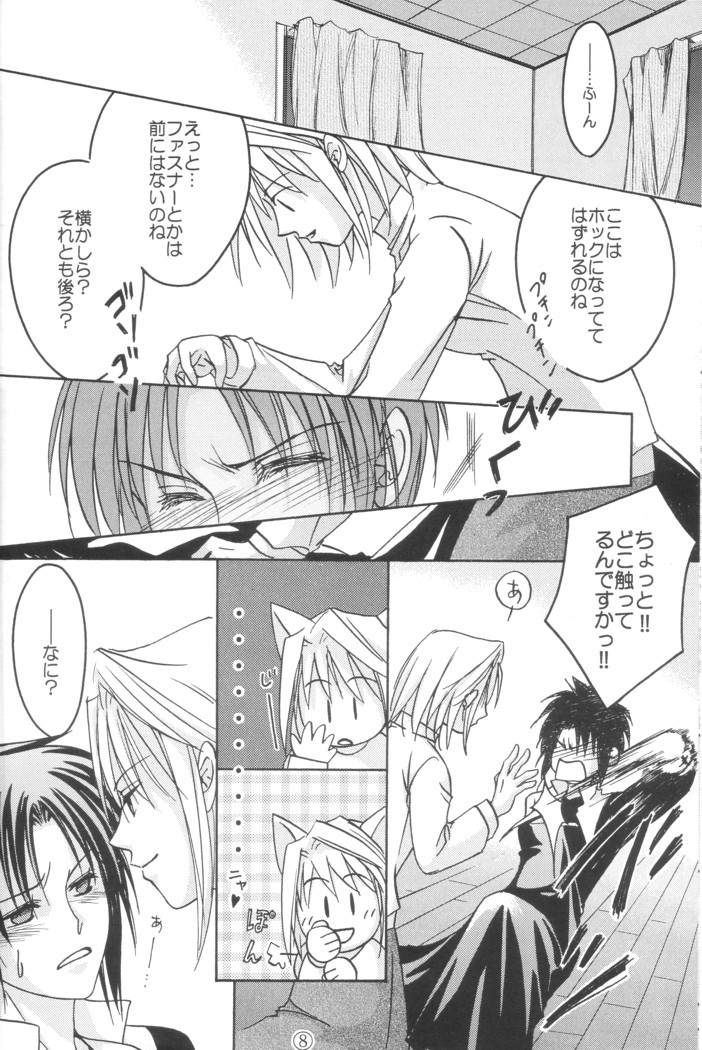

model/jpn_ver5
      悶                       ちょっと‼
疾                  旋也⁈
到尼                       かっ‼
o       ボッヅクになってて
加量倫了     系有旋外
92

ワ-スナーたかは
ヮスナーとかは
女路小

かしら?
評い千⁈

model/jpn_vert_new2
ふーん

いには
斥か怒盾選ってて
はずれるのね

!

トい稜

えっと…
ワァスサナーにかは
前にはないのね

横かしら?
それともを後ろ?

ちょっと
ピに強っに
るんですかっ


model/jpn_vert_v4
                       ちょつとリ
捉                  放っ
にて                       かつり
       ボックになってて
/、湾下     はずれるのね
の4v0全

ファスナーとかは
アスナーとかは
門にはないのね

かしら?
それとも後ろア

model/jpn_vert
                       ちょっとリ=
如                  旋軸っ
にては                       かっリ
       ホックになってて
/     はずれるのね
0人

ファスナーとかは
ァスナーとかは
記にはないのね

かしら?
それとも後ろ?



In [751]:
#test model

testImgPath='test/07.jpg'

img = Image.open(testImgPath)
display(img)
img = cv2.imread(testImgPath)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



oem=1
psm=1
traineddataList=glob('model/*.traineddata')


for traineddata in traineddataList:
    traineddata=traineddata.replace('.traineddata', '')
    
    ocr_result = pytesseract.image_to_string(image=img, lang=traineddata, config='--oem ' + str(oem) + ' --psm ' + str(psm))
    print(traineddata)
    print(ocr_result)


## change model config

In [ ]:

#extract current config
!combine_tessdata -u $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME

#list param list
# !tesseract --print-parameters

In [741]:
#update config
!combine_tessdata -o $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME".config"


Version:4.0.0-beta.3
0:config:size=2977, offset=192
17:lstm:size=13014691, offset=3169
18:lstm-punc-dawg:size=2714, offset=13017860
19:lstm-word-dawg:size=1007922, offset=13020574
20:lstm-number-dawg:size=978, offset=14028496
21:lstm-unicharset:size=281070, offset=14029474
22:lstm-recoder:size=66596, offset=14310544
23:version:size=12, offset=14377140


In [746]:


testImgPathList=glob("test/*.jpg")
traineddata=os.path.join(MODEL_DIR,OUTPUT_NAME)
configPath=os.path.join(MODEL_DIR,OUTPUT_NAME+".config")


configDict={

    
    "textord_max_noise_size":list(range(4,8,1)),
    "textord_minxh":list(np.arange(0.1,2,0.2)),
    "textord_min_linesize":list(np.arange(0.6,2.0,0.2)),
    "textord_overlap_x":list(np.arange(1,2,0.1)),
    "textord_occupancy_threshold":list(np.arange(1,5,1)),
    "textord_min_xheight":list(np.arange(0.5,2,0.1)),
    "textord_noise_area_ratio":list(np.arange(0.6,1.4,0.1)),
}




optionComboList=list(product(*configDict.values()))
optionNameList=list(configDict.keys())
random.shuffle(optionComboList)





def writeCsvLine(itemList,csvPath):
    with open(csvPath, 'a', newline ='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(itemList)
def removeFile(filePath):
    if os.path.exists(filePath):
        os.remove(filePath)
def openImage(imgPath):
    img = cv2.imread(imgPath)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def optionComboToList(optionNameList,optionCombo):
    result=[name+" "+str(val)+"\n" for name,val in zip(optionNameList,optionCombo)]
    return result
def optionStringToList(optionString):
    result=[s+"\n" for s in optionString.split('\n')]
    return result
    
def writeConfig(optionStringList,outConfigPath,inConfigPath):
    with open(inConfigPath, "r", encoding="UTF-8") as f:
        configLines = f.readlines()
        
    configLines+=optionStringList
    
    with open(outConfigPath, 'w', encoding="UTF-8") as f:
        f.writelines(configLines)

        
def testImage(imgPath,modelName,optionStringList=[],debug=True,showImg=False,showBox=False):
    with tempfile.TemporaryDirectory() as tmpPath:
        os.environ["TESSDATA_PREFIX"] =tmpPath

        bbox=""
        oem=1
        psm=1        
        tmpModelPath=os.path.join(tmpPath,modelName+".traineddata")
        tmpConfigPath=os.path.join(tmpPath,modelName+".config")            
        oriModelPath=os.path.join(MODEL_DIR,modelName+".traineddata")
        oriConfigPath=os.path.join(MODEL_DIR,modelName+".config")


        shutil.copyfile(oriModelPath, tmpModelPath) 
        
        if len(optionStringList)!=0:
            writeConfig(optionStringList,tmpConfigPath,oriConfigPath)
            !combine_tessdata -o $tmpModelPath $tmpConfigPath > /dev/null 2>&1
    
        
        img=openImage(imgPath)
        ocr_result = pytesseract.image_to_string(image=img, lang=modelName, config='--oem ' + str(oem) + ' --psm ' + str(psm))
        
        if showImg:   
            if showBox:
                bbox = pytesseract.image_to_data(image=img, lang=modelName, config='--oem ' + str(oem) + ' --psm ' + str(psm),  output_type='dict')        
            showImage(img,bbox)
        if debug:
            print(ocr_result)
            

    return ocr_result

def showImage(img,bbox=""):
    if bbox:
        d=bbox
        n_boxes = len(d['level'])
        for i in range(n_boxes):
            if d['width'][i]*d['height'][i]<10 :
                continue
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(img, )
    plt.show()


In [ ]:



optString="""

textord_max_noise_size  7
"""
optionList=optionStringToList(optString)
t=testImage(testImgPathList[0],OUTPUT_NAME,optionList,showImg=True,showBox=True)



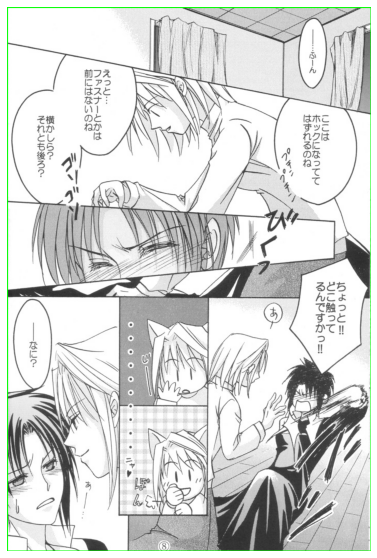


---------0.1


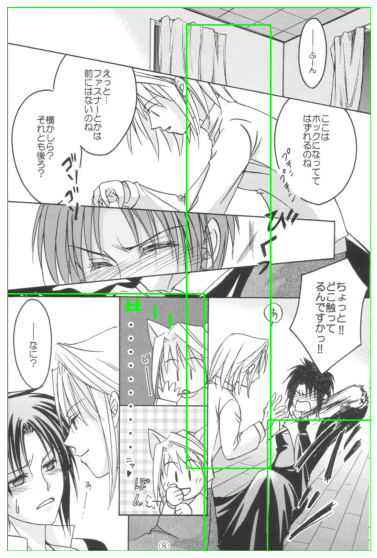


---------0.2


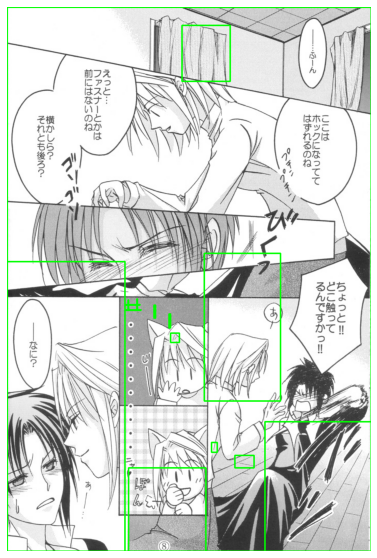


---------0.30000000000000004


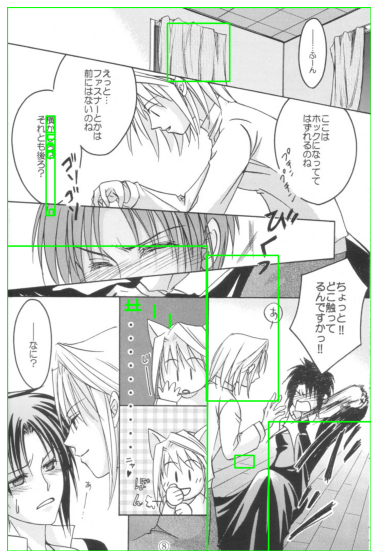

横かしら?              絲


---------0.4


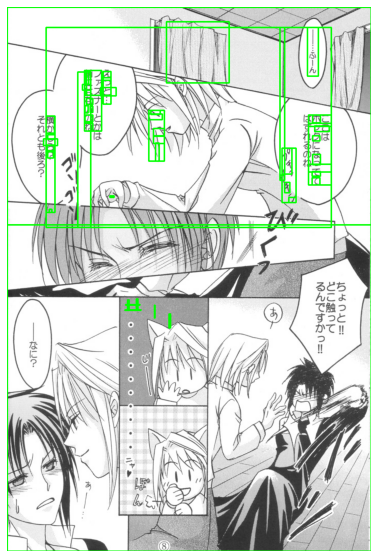

諒 た。に記ってて
9  衣絹
。 1
ぷぁ    ドやト
人
えっと…
宮 ないのね
自に上  …                      ”
横かしら?      区


---------0.5


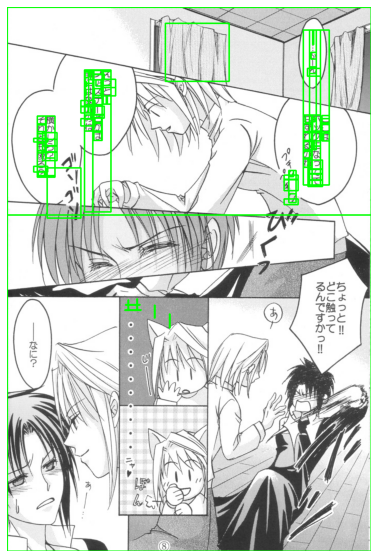

いには

諒ッ媚広ってて
ーふ人!         所    穫

はずれるのね

ルりい壬の

えっと…
ワファスナーにとかは
而にはないのね
下によ し

横かしら9
それともを後ろ?


---------0.6


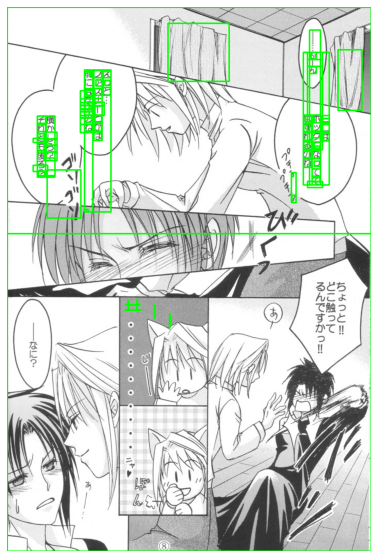

いには

斥か怒盾選ってて
ふーん            ボのの盾

はずれるのね

1 維

えっと
ワァスサナーにかは
庁にはないの          お
証にはないのね

横かしら?
それともを後ろ?


---------0.7000000000000001


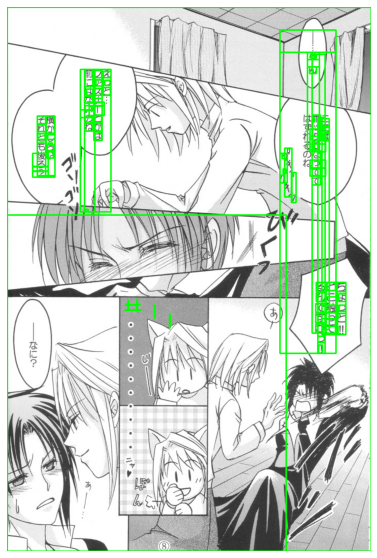

ちょっと

ピこ級って
レには                      半
区                          っド
い        諒ックになってて             るんですか
ふIん     盾  拒
1  維
1
のい錠

えっと
ワァスサナーにかは
前にはないのね         。

横かしら?
それとき後ろ?


---------0.8


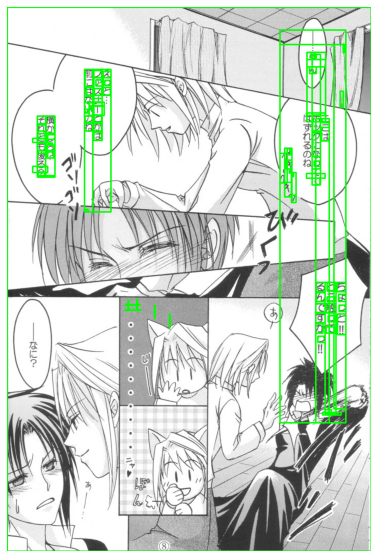

上     藻                     ちょっと
志こ了って       かタ
党先             るんですかっ      ま
“      う。直中にてて
ふーの
1鈴
りぅ人身
の

えっと
ワァスサナーにかは
前にはないのね         衝

横かしら?
それともを後ろ?


---------0.9


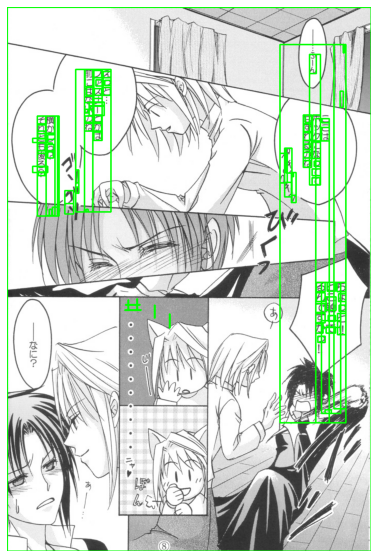

い    疏                   ちょっと
志二級にに       有
党先             るんですかっ      ま
や     訟誕惧らそ
はずれ私のね
1維
り勿
6

えっと
ワァスサナーにかは
前にはないのね         衝
ーぃ

9

多
摘かしら?      多
それともを後ろ?


---------1.0


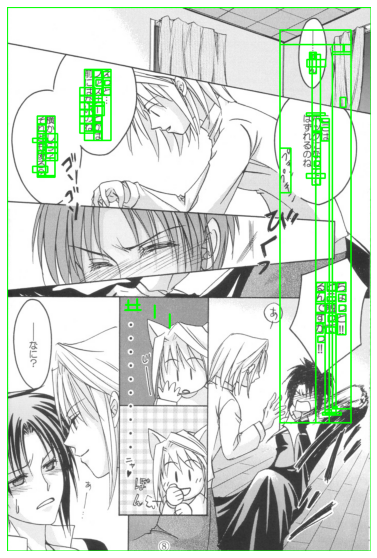

いッ     い                       ちょっと         を
志こ了って       かタ
党先             るんですかっ      ま
“      う。直中にてて
ふーの
8

えっと
ワァスサナーにかは
前にはないのね

横かしら?
それともを後ろ?

---------1.1


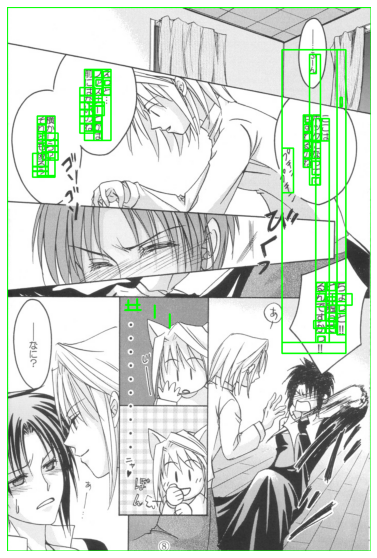

が       志                          ちょっと
ピこ級って
當              如ん琵すがっ
“     部氏中そ
はずれるのね
!

えっと
ワァスサナーにかは
前にはないのね

横かしら?
それとき後ろ?

---------1.2000000000000002


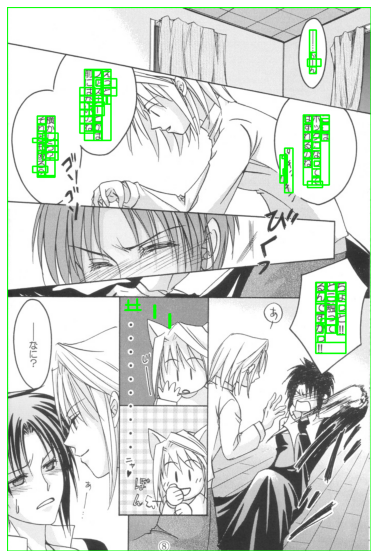

ふーん

いには
斥か怒盾選ってて
はずれるのね

!

トい稜

えっと…
ワァスサナーにかは
前にはないのね

横かしら?
それともを後ろ?

ちょっと
ピに強っに
るんですかっ


---------1.3000000000000003


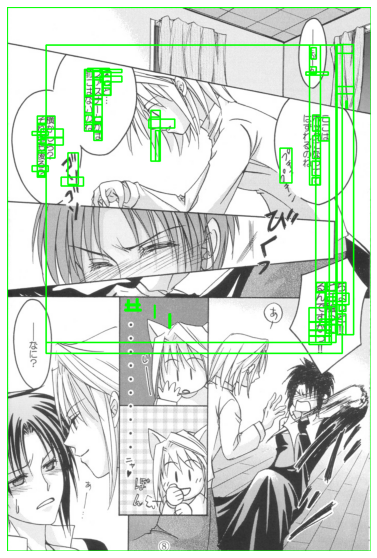

MIもM                 ちょっと

                 だに纏のの
た              るん配すがっ
る。かの     六穫中そ
!
ミこポ
た。ななを
う。っいはが“
写影疲の
修り
反かしち

てれらとき後ろ?

---------1.4000000000000001


In [747]:
# test 

    
optionNameList=["textord_min_linesize"]
for i in np.arange(0.1,1.5,0.1):
    optionCombo=[i]
    optionList=[]

    optString="""
    
textord_max_noise_size  7


textord_width_limit 2  
textord_underline_width 0.1


textord_minxh  0.8
textord_overlap_x 0.5
textord_min_xheight 1.3
textord_min_linesize 1.3
textord_occupancy_threshold 3

textord_noise_syfract 0.7
textord_noise_sxfract 0.7
textord_noise_hfract 0.2
textord_noise_area_ratio 1.1

    """
    optionList+=optionStringToList(optString)
    optionList+=optionComboToList(optionNameList,optionCombo)

    t=testImage(testImgPathList[3],OUTPUT_NAME,optionList,showImg=True,showBox=True)
    print("---------"+str(i))


    

In [ ]:
#test all image
optString="""

"""
optionList=optionStringToList(optString)

out = parmap.map(testImage, testImgPathList ,OUTPUT_NAME,optionList,showImg=True,showBox=True,  pm_pbar=True, pm_processes=16)



In [ ]:
#test all possible combo
def checkPerformance(optionCombo, lock, writeCsv=True):  
    optionStringList=optionComboToList(optionNameList,optionCombo)
    resultList=[]
    
    #for imgPath in testImgPathList:
    imgPath=testImgPathList[2]
    resultList+=[testImage(imgPath,OUTPUT_NAME,optionStringList,debug=False)]

    if writeCsv:
        with lock:
            totalLen = sum(len(s) for s in resultList)
            outputLine=list(optionCombo)+[totalLen]
            writeCsvLine(outputLine,csvPath)        

    return resultList




lock = Manager().Lock()
csvPath="test.csv"
testImgPathList=glob("test/*.jpg")

#csv reset
removeFile(csvPath)
writeCsvLine(optionNameList+["result"],csvPath)


# checkPerformance(optionComboList[1],lock)
y = parmap.map(checkPerformance, optionComboList, lock,  pm_pbar=True, pm_processes=16)


